Import thư viện

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
import os
import tarfile
import matplotlib.pyplot as plt
import numpy as np


Tải dữ liệu

In [3]:
#dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
##with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    #tar.extractall(path='./data_encoder')

train_ds=datasets.ImageFolder(root='./data_encoder/cifar10/train',transform=transforms.ToTensor())
test_ds=datasets.ImageFolder(root='./data_encoder/cifar10/test',transform=transforms.ToTensor())

batch_size=128
train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=batch_size,shuffle=False)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './data_encoder/cifar10/train'

Sử dụng GPU

In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def ConvLayer(inp, out, ks=3, s=1, p=1):
    return nn.Conv2d(inp,out,kernel_size=ks,stride=s,padding=p)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.neural_net = nn.Sequential (
            ConvLayer(3, 32), nn.ReLU(),
            ConvLayer(32, 64), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ConvLayer(64, 128), nn.ReLU(),
            ConvLayer(128, 256), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            ConvLayer(256, 512), nn.ReLU(),
            ConvLayer(512, 1024), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(1024*4*4, 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 10),
    )
    def forward(self, x):
        return self.neural_net(x)
model = CNN().to(device)

Hàm đánh giá

In [7]:
def accurate_score(out, labels):
    _, preds = torch.max(out, dim=1)
    correct_preds = torch.sum(preds == labels).item()
    total_preds = len(preds)
    accuracy = torch.tensor(correct_preds / total_preds)
    return accuracy

Training model

In [8]:
num_epochs = 15
learning_rate = 0.003
loss_func= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    total_testing_accuracies = []
    for img, labels in train_loader:
        img =img.to(device)
        labels = labels.to(device)
        pred = model(img)
        loss = loss_func(pred, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_pred = model(test_img)
        metrics = accurate_score(test_pred, test_labels)
        total_testing_accuracies.append(metrics)
    print("Epoch Number: ", epoch, "Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))

NameError: name 'train_loader' is not defined

Lưu mô hình

Label: automobile , Predicted: automobile


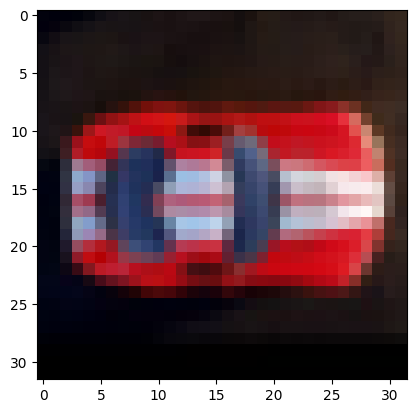

In [ ]:
data_dir = './data_encoder/cifar10'
classes = os.listdir(data_dir + "/train")

def predict_image(img, model):
   img = img.unsqueeze(0).to(device)
   output = model(img)
   _, pred = torch.max(output, dim=1)
   return train_ds.classes[pred[0].item()]
img, label = test_ds[1004]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
torch.save(model, 'CNN.pth')

NameError: name 'torch' is not defined